In [18]:
#importing the requests library
# import requests
import pandas as pd
# import json
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline
# from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
# from scipy.signal._signaltools import _centered
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
# from pmdarima import auto_arima
import numpy as np
import yfinance as yf #using the yahoo finance library 
from yahoofinancials import YahooFinancials
import warnings
warnings.filterwarnings('ignore')

Getting stock data using the open source yahoo finance library. More information can be found [here](https://pypi.org/project/yfinance/)

In [2]:
#function to get stock data of a company
start_date = '2017-01-01'
end_date = '2022-12-31'

def stock_info(ticker):
    #get stock prices for the specified date ranges
    df = yf.download(ticker,start=start_date,end=end_date)
    #plot the stock price over the years
    fig,ax = plt.subplots(figsize=(15,5))
    ax.plot(df['Adj Close']);
    ax.set_title(f'Stock Price of {ticker} from 2017 to 2022')
    return ax

In [3]:
#function to calculate stock return

def stock_return(ticker):
    #get stock prices for the specified date ranges
    df = yf.download(ticker,start=start_date,end=end_date)
    df_return = df[['Adj Close']]
    df_return['pct_change'] = df_return['Adj Close'].pct_change() # use pct change to calculate the diff 
    df_return.drop(df_return.index[0],inplace=True) # drop the Nan value from the first row
    
    #plot the returns over 5 years
    fig,ax=plt.subplots(figsize=(15,5))
    ax.plot(df_return['pct_change']);
    plt.title('Stock Return Pct from 2017 to 2022:' +' ' + ticker)
      

In [4]:
#function to calculate beta value of stock

def calculate_beta(ticker):
    
    #get data for ticker and SPY whih serves as the market index
    symbols = [ticker,'SPY']
    data = yf.download(symbols, start = '2019-01-01',end = '2022-12-31')['Adj Close']
    price_change = data.pct_change()
    price_change.drop(price_change.index[0],inplace=True)
    
    #reshape for linear regression
    X = np.array(price_change[ticker]).reshape((-1,1))
    y = np.array(price_change['SPY'])

    #create splits
    X_train,X_test,y_train,y_test = train_test_split(X,y)
    lr = LinearRegression()
    lr.fit(X_train,y_train)

    #predictions
    y_preds = lr.predict(X_test)

    #plot 
    fig,ax = plt.subplots(figsize=(8,8));
    ax.plot(X_test,y_preds,linestyle=':',color='orange')
    ax.scatter(y_test,y_preds,alpha=0.5)
    ax.set_title(f' Beta value = {lr.coef_}')
    ax.set_xlabel('Market Index:SPY')
    ax.set_ylabel(f'{ticker} value')
    plt.show();
    
    return ax

In [5]:
#function to get historical PE ratios

def get_pe_ratio(ticker):
    
    #get financial statement of ticker using yahoofinancials
    financials = YahooFinancials(ticker)
    statement = financials.get_financial_stmts('annual', 'income', reformat=True)    
    
    #create a dict of the income statement alone
    dicts ={}
    for i in statement['incomeStatementHistory'][ticker]:
        dicts.update(i)
    
    #create a dataframe for easy use
    df = pd.DataFrame(dicts)
    df = df.T
    df['dilutedAverageShares'].fillna(df['dilutedAverageShares'].median(),inplace=True)
    
    #calculate pe ratio
    eps = df['netIncomeContinuousOperations']/df['dilutedAverageShares'] #calc earnings per share
    eps_df = pd.DataFrame(eps,index=df.index,columns=['EPS'])
    eps_df['PE ratio'] = financials.get_current_price()/eps_df['EPS']#get current price and calc pe ratio
    
    #plot result
    fig,ax=plt.subplots(figsize=(8,8));
    ax.plot(eps_df['PE ratio'],marker = '*', markerfacecolor = 'black')
    ax.set_title(f'Historical PE ratio: {ticker}')
    ax.set_ylabel('PE ratio')
    plt.show()
    
    return ax

In [6]:
#function to get historical dividend data

def get_dividend(ticker):
    
    #get dividend data
    financials = YahooFinancials(ticker)
    div = financials.get_daily_dividend_data(start_date=start_date,end_date=end_date)
    
    #check if the company pays dividends
    if div[ticker] == None:
        fig,ax = plt.subplots(figsize=(5,5))
        ax.annotate(f'Sorry, {ticker} does not offer dividends',xy=(0.3,0.5),fontsize=20);
        ax.axis('off')
        return fig,ax
    
    else:#if company does pay dividends,then convert to a df and create a plot
        df = pd.DataFrame(div[ticker])
        df.drop('date',axis=1,inplace=True)
        df.rename(columns={'formatted_date':'date'},inplace=True)
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date',inplace=True)
        fig,ax=plt.subplots(figsize=(8,8))
        ax.plot(df['amount']);
        ax.set_title(f'Dividend rate: {ticker}');
        
    return ax

In [7]:
def summary_info(ticker):
    return stock_info(ticker),stock_return(ticker),calculate_beta(ticker),get_pe_ratio(ticker),get_dividend(ticker)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  2 of 2 completed


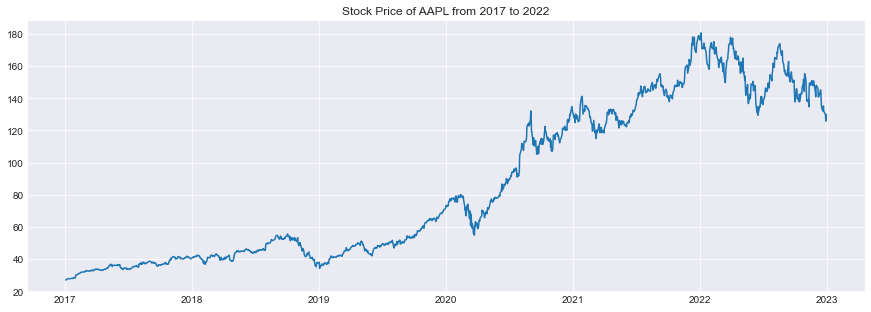

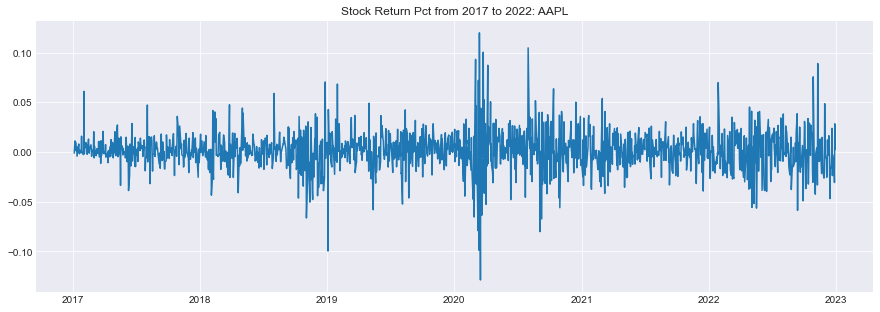

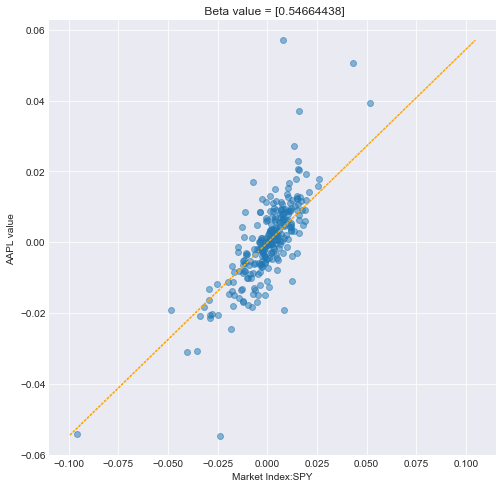

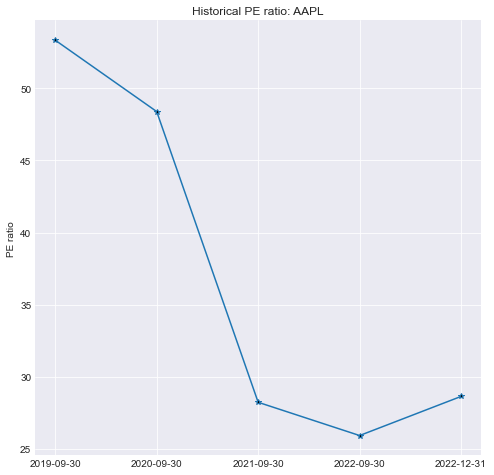

(<AxesSubplot:title={'center':'Stock Price of AAPL from 2017 to 2022'}>,
 None,
 <AxesSubplot:title={'center':' Beta value = [0.54664438]'}, xlabel='Market Index:SPY', ylabel='AAPL value'>,
 <AxesSubplot:title={'center':'Historical PE ratio: AAPL'}, ylabel='PE ratio'>,
 <AxesSubplot:title={'center':'Dividend rate: AAPL'}>)

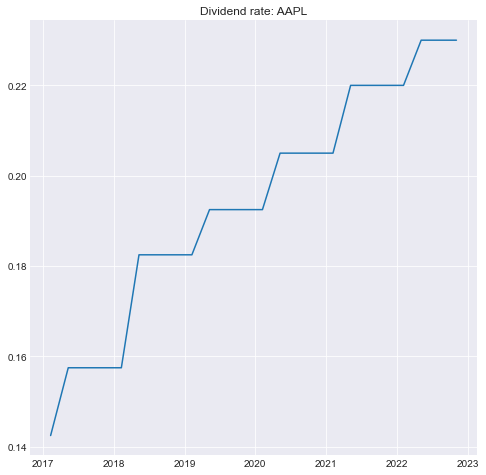

In [8]:
summary_info('AAPL')

# Stationarity Check

In [9]:
def plot_trends(ticker):
    df = yf.download(ticker,start=start_date,end=end_date)
    close = df.loc[:,['Adj Close']]

#compute rolling mean and std to see if they are constant
    roll_mean = close.rolling(window=30,center=False).mean()
    roll_std = close.rolling(window=30,center=False).std()

#plot the data
    fig,ax=plt.subplots(figsize=(15,5))
    ax.plot(close,color='blue',label='Original')
    ax.plot(roll_mean,color='red',label='Rolling Mean')
    ax.plot(roll_std,color='green',label='Rolling StdDev')
    ax.legend(loc='best')
    ax.set_title(f'Rolling Statistics of {ticker}');

#dickey Fuller Test
    dftest = adfuller(close['Adj Close'])
    dfoutput = pd.DataFrame(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'],columns=['Values'])
    
    return ax,dfoutput

[*********************100%***********************]  1 of 1 completed


(<AxesSubplot:title={'center':'Rolling Statistics of AAPL'}>,
                                   Values
 Test Statistic                 -0.991705
 p-value                         0.756278
 #Lags Used                     11.000000
 Number of Observations Used  1498.000000)

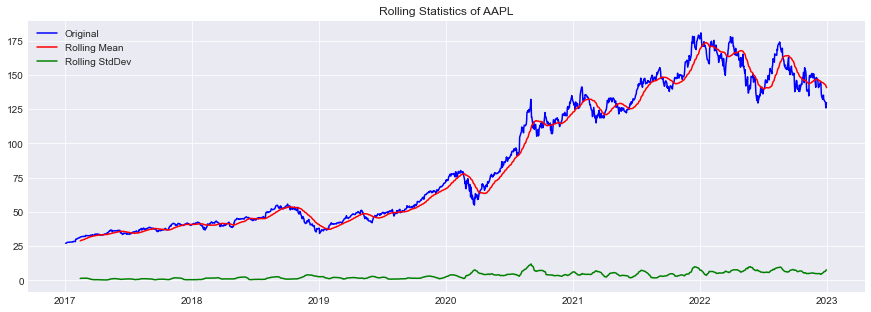

In [10]:
plot_trends('AAPL')

# Convert non-stationary to stationary 

In [70]:
def differencing(ticker):
    df = yf.download(ticker,start=start_date,end=end_date)
    df_return = df[['Adj Close']]
    df_diff =df_return.diff(periods=1)
    df_diff.dropna(inplace=True)
    
    #plot the results
    fig,ax = plt.subplots(figsize = (12,8));
    ax.plot(df_diff, label = 'Differenced');
    ax.plot(df_diff.rolling(30).mean(),label = 'Rolling Mean')
    ax.plot(df_diff.rolling(30).std(),label = 'Rolling StdDev')
    ax.set_title(f'Differenced plot of {ticker}')
    ax.legend(loc=2);
    
    #dickey fuller test
    dftest = adfuller(df_diff['Adj Close'])
    dfoutput = pd.DataFrame(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'],columns=['Values'])
    
    return ax,dfoutput

[*********************100%***********************]  1 of 1 completed


(<AxesSubplot:title={'center':'Differenced plot of AAPL'}>,
                                    Values
 Test Statistic              -1.147513e+01
 p-value                      5.153199e-21
 #Lags Used                   1.000000e+01
 Number of Observations Used  1.498000e+03)

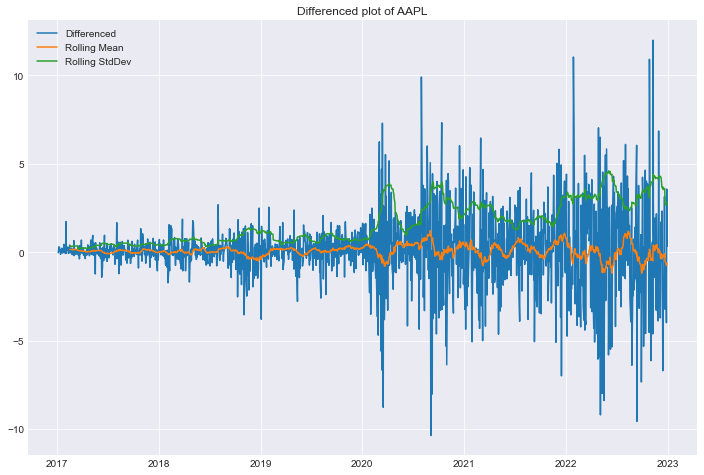

In [71]:
differencing('AAPL')

# using df as trial run for ACF and PACF

In [13]:
df = yf.download('AAPL',start=start_date,end=end_date)
df=df[['Adj Close']]
size = df.shape
cutoff = round(size[0]*0.75)
train = df[:cutoff]
test = df[cutoff:]

[*********************100%***********************]  1 of 1 completed


## Baseline

# AR model

In [15]:
ar_1 = ARIMA(train,order=(1,1,0)).fit()
preds=ar_1.predict(typ='levels')
np.sqrt(mean_squared_error(train,preds))

1.7126018843858484

# MA model

In [16]:
ma_1 = ARIMA(train,order=(0,1,1)).fit()
preds=ma_1.predict(typ='levels')
np.sqrt(mean_squared_error(train,preds))

1.7131783941297787

# ARIMA

In [17]:
arima_1 = ARIMA(train,order=(1,1,1)).fit()
preds=arima_1.predict(typ='levels')
np.sqrt(mean_squared_error(train,preds))

1.7120047132581602

In [79]:
preds

Date
2017-01-03      0.000000
2017-01-04     27.133324
2017-01-05     27.106544
2017-01-06     27.224106
2017-01-09     27.513811
                 ...    
2021-06-25    132.064517
2021-06-28    131.779912
2021-06-29    133.206706
2021-06-30    134.809933
2021-07-01    135.520754
Name: predicted_mean, Length: 1132, dtype: float64

# Predictions

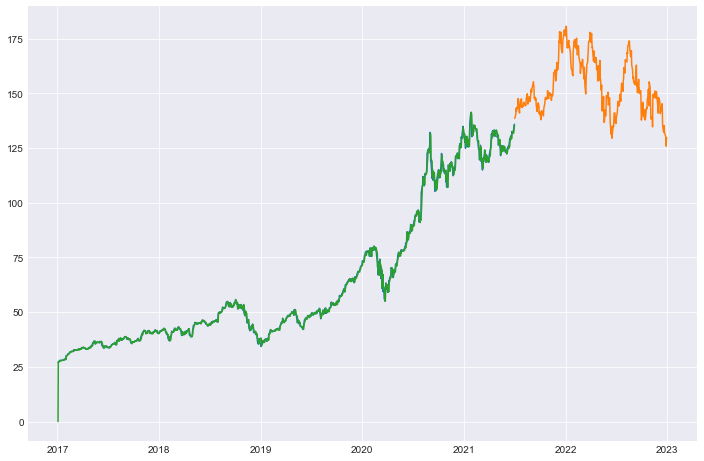

In [80]:
fig,ax=plt.subplots(figsize=(12,8))
ax.plot(train)
ax.plot(test)
ax.plot(preds)